In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

# Generate Data

In [4]:
using Random: shuffle!, AbstractRNG, Xoshiro

In [5]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [6]:
n_hd = 512
n_batch = 128

128

In [7]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [8]:
function choose_symbols(n_samples::Int, n_symbols::Int, d_vsa::Int, rng::AbstractRNG)
    codebook = random_symbols((d_vsa, n_symbols), rng)
    selection = rand(rng, 1:n_symbols, n_samples)
    return selection, codebook
end

choose_symbols (generic function with 1 method)

In [9]:
a, b = choose_symbols(20, n_batch, n_hd, rng)

([93, 48, 4, 11, 85, 63, 92, 22, 68, 60, 110, 23, 38, 128, 46, 94, 97, 80, 36, 41], [-0.0910341739654541 -0.824973464012146 … -0.06740546226501465 0.8688455820083618; -0.652850866317749 -0.8821024894714355 … 0.7837827205657959 -0.3686896562576294; … ; -0.1820603609085083 -0.3686501979827881 … 0.7178592681884766 -0.8282173871994019; -0.8696286678314209 -0.9998259544372559 … -0.931610107421875 -0.7670974731445312])

In [10]:
a |> size

(20,)

In [11]:
b |> size

(512, 128)

In [12]:
function select_edges(n_samples::Int, n_links::Tuple{<:Int, <:Int}, rng::AbstractRNG)
    ids = collect(1:n_samples)
    links_per_sample = rand(rng, n_links, n_samples)
    edges = [ids[rand(rng, 1:n_samples, n)] for n in links_per_sample]
    return edges
end

select_edges (generic function with 1 method)

In [13]:
select_edges(20, (1,3), rng)

20-element Vector{Vector{Int64}}:
 [15]
 [16]
 [2]
 [14]
 [3]
 [13, 19, 9]
 [20]
 [19, 15, 9]
 [16, 12, 8]
 [2, 15, 12]
 [6, 11, 17]
 [10]
 [3, 9, 1]
 [16, 19, 6]
 [6]
 [18]
 [7, 13, 13]
 [10]
 [4]
 [16, 5, 1]

In [14]:
function generate_addresses(n_samples::Int,  n_vsa::Int, rng::AbstractRNG)
    header = random_symbols((n_vsa, 1), rng)
    powers = collect(0:n_samples-1)
    addresses = [v_bind(header, header .* p)[:,1] for p in powers]
    addresses = stack(addresses, dims=2)
    return header, addresses
end

generate_addresses (generic function with 1 method)

In [15]:
h, ad = generate_addresses(20, n_hd, rng)

([-0.377943754196167; -0.9322184324264526; … ; 0.039890289306640625; -0.1195073127746582;;], [-0.377943754196167 -0.755887508392334 … 0.8190686702728271 0.44112491607666016; -0.9322184324264526 0.13556313514709473 … 0.2878497838973999 -0.6443686485290527; … ; 0.039890289306640625 0.07978057861328125 … 0.7579154968261719 0.7978057861328125; -0.1195073127746582 -0.2390146255493164 … -0.27063894271850586 -0.39014625549316406])

In [16]:
skv = [similarity(h, v_bind(h, p .* h))[1] for p in 0.0:0.01:5.0];

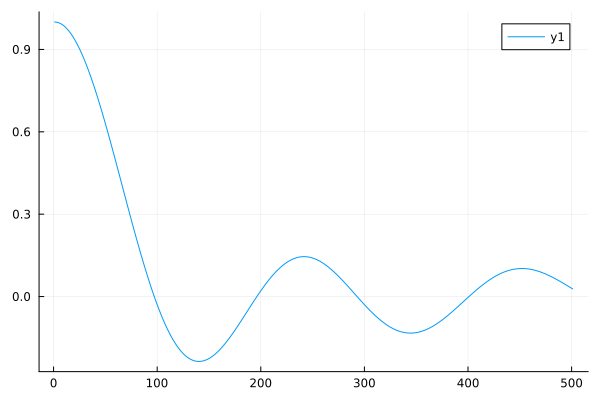

In [17]:
plot(skv)

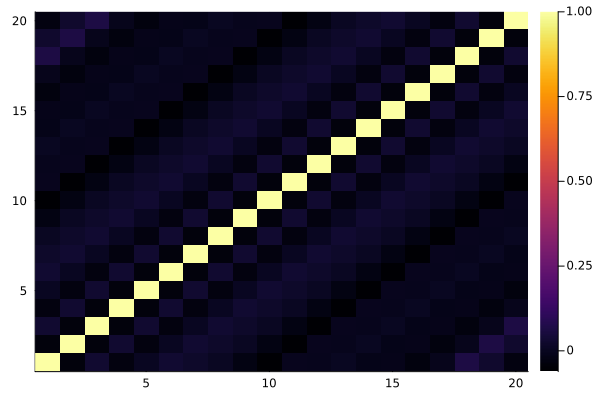

In [18]:
heatmap(similarity_outer(ad[:,:,1:1], ad[:,:,1:1], dims=2)[:,:,1])

In [19]:
struct KeyValueData
    color_marker::AbstractArray{<:Real,2}
    colors::AbstractArray{<:Real,2}
    color_bank::AbstractArray{<:Real,2}
    color_choices::AbstractArray{<:Int,1}

    shape_marker::AbstractArray{<:Real,2}
    shapes::AbstractArray{<:Real,2}
    shape_bank::AbstractArray{<:Real,2}
    shape_choices::AbstractArray{<:Int,1}

    location_marker::AbstractArray{<:Real,2}
    locations::AbstractArray{<:Real,2}
    location_index::AbstractArray{<:Int,1}

    link_marker::AbstractArray{<:Real,2}
    links::AbstractVector{AbstractArray{<:Real,2}}
    link_choices::AbstractVector{AbstractVector{<:Int}}

    symbols::AbstractArray{<:Real,2}
end

In [81]:
function KeyValueData(n_samples::Int; n_colors::Int = 100, n_shapes::Int = 20, n_links::Tuple{<:Int, <:Int} = (1,3), d_vsa::Int = 512, rng::AbstractRNG)
    generate_marker = () -> random_symbols((d_vsa, 1), rng)

    #colors
    color_marker = generate_marker()
    color_choices, color_bank = choose_symbols(n_samples, n_colors, d_vsa, rng)
    colors = color_bank[:,color_choices]

    #shapes
    shape_marker = generate_marker()
    shape_choices, shape_bank = choose_symbols(n_samples, n_shapes, d_vsa, rng)
    shapes = shape_bank[:,shape_choices]

    #locations
    location_marker = generate_marker()
    _, locations = generate_addresses(n_samples, d_vsa, rng)
    locations_indices = collect(1:n_samples)

    #links
    link_marker = generate_marker()
    link_indices = select_edges(n_samples, n_links, rng)
    links = [locations[:,idx] for idx in link_indices]

    #combine data
    symbols = zeros(Float64, (d_vsa, n_samples))
    for i in 1:n_samples
        color_string = v_bind(color_marker, colors[:, i:i])
        shape_string = v_bind(shape_marker, shapes[:, i:i])
        location_string = v_bind(location_marker, locations[:, i:i])

        link_strings = stack([locations[:, l] for l in link_indices[i]], dims=2)
        link_string = v_bind(link_marker, v_bundle(link_strings, dims=2))

        string = v_bundle(stack([color_string, shape_string, location_string, link_string], dims=2), dims=2)
        symbols[:,i:i] = string
    end

    return KeyValueData(color_marker,
                         colors,
                         color_bank,
                         color_choices,
                         shape_marker,
                         shapes,
                         shape_bank,
                         shape_choices,
                         location_marker,
                         locations,
                         locations_indices,
                         link_marker,
                         links,
                         link_indices,
                         symbols)

    # return KeyValueData(color_marker,
    #                      colors,
    #                      color_choices,
    #                      shape_marker,
    #                      shapes,
    #                      shape_choices,
    #                      location_marker,
    #                      locations,
    #                      locations_indices,
    #                      link_marker,
    #                      links,
    #                      link_indices,
    #                      symbols)
    
end

KeyValueData

In [82]:
kv = KeyValueData(32, rng=rng)

KeyValueData([-0.6609688997268677; 0.11829209327697754; … ; 0.7630347013473511; -0.33201372623443604;;], [-0.14844942092895508 -0.3561636209487915 … -0.2601393461227417 0.540817379951477; 0.1977320909500122 -0.2569233179092407 … 0.6179171800613403 -0.41671979427337646; … ; -0.5868391990661621 -0.07147598266601562 … 0.4305919408798218 0.9454135894775391; -0.5315686464309692 0.12572991847991943 … -0.495436429977417 -0.45965754985809326], [0.3747774362564087 -0.9907903671264648 … 0.395147442817688 0.656678318977356; -0.077789306640625 -0.5875569581985474 … -0.4810676574707031 -0.008990049362182617; … ; 0.064483642578125 -0.7820388078689575 … -0.8489400148391724 0.3536146879196167; 0.26328110694885254 0.5043693780899048 … 0.646367073059082 0.06094837188720703], [88, 56, 65, 14, 2, 31, 38, 48, 9, 34  …  21, 22, 84, 2, 11, 29, 61, 40, 26, 32], [0.4557253122329712; -0.18233931064605713; … ; -0.786970853805542; -0.11414897441864014;;], [0.003992199897766113 -0.44256508350372314 … 0.78938412666

In [83]:
kv.color_marker

512×1 Matrix{Float64}:
 -0.6609688997268677
  0.11829209327697754
  0.25462889671325684
 -0.34254932403564453
  0.13406050205230713
  0.6915394067764282
  0.6427904367446899
  0.354839563369751
  0.9599587917327881
  0.8867641687393188
  0.877643346786499
  0.061644792556762695
 -0.014034867286682129
  ⋮
 -0.8884453773498535
 -0.37621474266052246
 -0.33560216426849365
  0.1984950304031372
 -0.18506479263305664
 -0.5211745500564575
 -0.8145052194595337
 -0.30157768726348877
 -0.9408270120620728
 -0.6212941408157349
  0.7630347013473511
 -0.33201372623443604

In [84]:
import Base.length, Base.size

function length(kv::KeyValueData)
    return size(kv.locations,2)
end

function size(kv::KeyValueData)
    return kv.locations |> size
end

size (generic function with 441 methods)

In [85]:
length(kv)

32

In [86]:
kv_fields = [:color, :shape, :link, :location]

4-element Vector{Symbol}:
 :color
 :shape
 :link
 :location

In [87]:
function generate_direct_query(marker::Symbol, index::Int, kvs::KeyValueData)
    @assert index in 1:length(kvs) "Select an index within length(kvs) to query"
    @assert marker in kv_fields "Must choose valid subfield to query"    

    address = v_bind(kvs.location_marker, kvs.locations[:, index:index])

    #generate the query
    if marker == :color
        tag = kvs.color_marker
        value = kvs.colors[:, index:index]
    elseif marker == :shape
        tag = kvs.shape_marker
        value = kvs.shapes[:, index:index]
    elseif marker == :link
        tag = kvs.link_marker
        value = v_bundle(kvs.links[index], dims=2)
    else marker == :location
        tag = kvs.location_marker
        value = kvs.locations[:, index:index]
    end

    query = v_bundle(address, tag, dims=2)
    return query, value
end

generate_direct_query (generic function with 1 method)

In [88]:
dqx, dqy = generate_direct_query(:link, 10, kv)

([0.33889567852020264; -0.6204671263694764; … ; -0.9505822976309922; 0.12407517433166508;;], [0.7305497391166228; -0.5726779449585216; … ; 0.45284286893053777; -0.0033733500932456757;;])

In [89]:
dqx

512×1 Matrix{Float64}:
  0.33889567852020264
 -0.6204671263694764
  0.3339078426361084
 -0.1908971071243286
 -0.15025120973587033
 -0.11136192083358765
 -0.283702552318573
  0.7099288105964661
  0.11861568689346312
 -0.1821538209915161
 -0.5570960640907288
 -0.2878563404083252
  0.299521267414093
  ⋮
 -0.15003883838653564
 -0.025177717208862308
 -0.6835280060768127
 -0.43104618787765503
  0.8457047343254089
 -0.5375031232833862
 -0.22141337394714358
  0.7181226928908494
 -0.25886023044586176
 -0.2711062431335449
 -0.9505822976309922
  0.12407517433166508

In [90]:
dqy

512×1 Matrix{Float64}:
  0.7305497391166228
 -0.5726779449585216
 -0.15688624156601247
 -0.03268370813781135
 -0.9782170655802271
 -0.7019257957146172
  0.8537116041271509
 -0.2619843583759578
 -0.4658873952528315
 -0.7022055919948338
 -0.8199977664199979
 -0.18743277727720684
  0.35586088737830546
  ⋮
  0.5481150650936816
  0.6099228963932831
 -0.8200860204353854
  0.3060049210865598
 -0.09525620439536639
  0.044584381141011944
 -0.17665601225445804
 -0.23969944685633954
 -0.7121960587603207
 -0.8550083330782681
  0.45284286893053777
 -0.0033733500932456757

In [91]:
function generate_indirect_query(marker::Symbol, index::Int, kvs::KeyValueData)
    @assert index in 1:length(kvs) "Select an index within length(kvs) to query"
    @assert marker in kv_fields "Must choose valid subfield to query"    

    address = kvs.locations[:, index:index]
    link = kvs.link_marker
    link_indices = kvs.link_choices[index]

    #bundle together the result of the query from the child nodes
    function bundle_values(register, indices)
        values = register[:, indices]
        value = v_bundle(values, dims=2)
        return value
    end

    if marker == :color
        tag = kvs.color_marker
        value = bundle_values(kvs.colors, link_indices)
    elseif marker == :shape
        tag = kvs.shape_marker
        value = bundle_values(kvs.shapes, link_indices)
    elseif marker == :link
        tag = kvs.link_marker
        values = cat((kvs.links[link_indices]...), dims=2)
        #return values
        value = v_bundle(values, dims=2)
    else marker == :location
        tag = kvs.location_marker
        value = bundle_values(kvs.locations, link_indices)
    end

    reference = v_bundle(v_bind(kvs.location_marker, address, dims=2), kvs.link_marker, dims=2)
    query = v_bundle(v_bind(kvs.location_marker, reference, dims=2), tag, dims=2)
    return query, value
end

generate_indirect_query (generic function with 1 method)

In [92]:
iqx, iqy = generate_indirect_query(:link, 10, kv)

([0.5270666480064392; -0.9889369030673173; … ; 0.32880262931789617; 0.6944502592086792;;], [-0.4447365078041027; 0.33465587121634893; … ; -0.552553480683535; -0.5341092704051926;;])

In [93]:
iqx

512×1 Matrix{Float64}:
  0.5270666480064392
 -0.9889369030673173
 -0.8602027614791047
 -0.7303387522697449
 -0.2897699773311615
 -0.6351254006106525
 -0.08316650986671448
  0.9420693536479142
  0.4258467853069306
  0.332660973072052
  0.05045452713966366
  0.22187626361846924
 -0.07525983452796936
  ⋮
 -0.2720866799354553
 -0.016004681587219242
 -0.3919470012187958
  0.8048631568629411
 -0.700385274477687
  0.019389092922210707
 -0.274541974067688
  0.7542521536169747
 -0.8531917651374009
 -0.16442692279815677
  0.32880262931789617
  0.6944502592086792

In [94]:
iqy

512×1 Matrix{Float64}:
 -0.4447365078041027
  0.33465587121634893
 -0.9908497995697187
 -0.7097188170678504
  0.1862913396645237
  0.12885132719855583
 -0.37074663638045485
  0.686211607883862
  0.5432185929928536
  0.9839517523288078
  0.36251373265474973
  0.9599267893567117
  0.07348168849554286
  ⋮
 -0.460692054580795
 -0.9025125435966779
  0.9304871262338987
  0.9103589359334818
 -0.09851280885935171
 -0.8251309235915572
 -0.18270650258534618
 -0.932057682975257
 -0.07583212704406314
  0.003970952249920447
 -0.552553480683535
 -0.5341092704051926

In [95]:
function permute_shuffle(n_samples::Int, kvs::KeyValueData, rng::AbstractRNG)
    n_permutations = length(kv_fields) * length(kvs)
    @assert n_samples < n_permutations "Must have n_samples < n_permutations for unique samples"

    #select which queries to make at random
    permutations = [(field, i) for field in kv_fields, i in 1:length(kvs)]
    permutations = shuffle!(rng, permutations)[1:n_samples]
    return permutations
end

permute_shuffle (generic function with 1 method)

In [96]:
function direct_dataset(n_samples::Int, kvs::KeyValueData, rng::AbstractRNG)
    permutations = permute_shuffle(n_samples, kvs, rng)
    samples = map(x -> generate_direct_query(x[1],x[2],kvs), permutations)
    queries = stack([s[1][:] for s in samples])
    values = stack([s[2][:] for s in samples])
    return queries, values
end

direct_dataset (generic function with 1 method)

In [97]:
ddx, ddy = direct_dataset(100, kv, rng)

([0.7139398455619812 -0.2219395041465759 … 0.40585601329803467 0.5002390742301941; -0.6007113774497178 -0.1202791929244995 … -0.5239087343215942 0.8935621102530625; … ; -0.7961989641189575 -0.9155848344046739 … 0.3529899120330811 0.3265870809555052; 0.30924081802368164 -0.7896865328032641 … -0.7523618658263354 0.4951368570327759], [0.7956358194351196 0.6313729286193848 … -0.4524247646331787 -0.26365864276885986; -0.7115620374679565 -0.8703799247741699 … 0.5630614757537842 -0.6019967794418335; … ; -0.08150804042816162 0.7093359231948853 … -0.913093090057373 -0.9658987522125244; -0.45306265354156494 0.1602994203567505 … 0.9766550064086914 -0.5283474922180176])

In [98]:
ddx |> size

(512, 100)

In [99]:
ddy |> size

(512, 100)

In [100]:
function indirect_dataset(n_samples::Int, kvs::KeyValueData, rng::AbstractRNG)
    permutations = permute_shuffle(n_samples, kvs, rng)
    samples = map(x -> generate_indirect_query(x[1],x[2],kvs), permutations)
    queries = stack([s[1][:] for s in samples])
    values = stack([s[2][:] for s in samples])
    return queries, values
end

indirect_dataset (generic function with 1 method)

In [101]:
idx, idy = indirect_dataset(100, kv, rng)

([0.6599416434764862 -0.9109170456607011 … 0.4430908262729645 0.5846654176712037; 0.7581206420997215 0.19569356640781632 … -0.9894666989524034 -0.863260418176651; … ; 0.37384955486263494 -0.9304802437503007 … -0.7053589383700923 -0.7449631710726884; 0.9501000364501145 -0.35640086134876486 … -0.8074036697486475 -0.9361555298049119], [0.22166013693699185 0.84561075588707 … 0.542932529268166 -0.7795864883389342; -0.10841702739392704 -0.614594735017059 … -0.24531810485147792 -0.45318367895690176; … ; 0.42009538405158414 0.8975899184539113 … 0.1848241799072802 0.700947594440126; -0.036675145454497564 -0.4594646309447104 … -0.5144666625334918 -0.1638287564900076])

In [102]:
idx |> size

(512, 100)

In [103]:
idy |> size

(512, 100)

# Setup an xformer network

In [104]:
struct SingleHeadAttention <: LuxCore.AbstractLuxContainerLayer{(:q_proj, :k_proj, :v_proj, :out_proj)}
    q_proj
    k_proj
    v_proj
    out_proj
end

In [105]:
function SingleHeadAttention(d_input::Int, d_model::Int; init=variance_scaling)
    SingleHeadAttention(
        PhasorDense(d_input => d_model; init),  # Query
        PhasorDense(d_input => d_model; init),  # Key
        PhasorDense(d_input => d_model; init),  # Value
        PhasorDense(d_model => d_input; init)   # Output
    )
end

SingleHeadAttention

In [124]:
function (m::SingleHeadAttention)(q, kv, ps, st)
    q = m.q_proj(q, ps.q_proj, st.q_proj)[1]
    k = m.k_proj(kv, ps.k_proj, st.k_proj)[1]
    v = m.v_proj(kv, ps.v_proj, st.v_proj)[1]
    
    # Single-head attention (nheads=1)
    attn_out = attend(q, k, v)
    output = m.out_proj(attn_out, ps.out_proj, st.out_proj)[1]
    
    return output, ()
end

In [125]:
identity_layer = Chain(x -> x,)

Chain(
    layer_1 = WrappedFunction(#82),
)         # Total: 0 parameters,
          #        plus 0 states.

In [152]:
n1 = Chain(PhasorDense(n_hd => n_hd),)

Chain(
    layer_1 = PhasorDense((512, 512)),  # 263_168 parameters
)         # Total: 263_168 parameters,
          #        plus 0 states.

In [158]:
typeof((1,3,4)) <: Tuple{Vararg{<:Int}}

true

In [153]:
p1 = Lux.setup(rng, n1, )

((layer_1 = (weight = Float32[0.05139024 0.00070409646 … 0.006261798 0.03992668; 0.01517952 -0.029263446 … 0.047135353 0.03677933; … ; -0.0031150102 0.0138904825 … 0.017896488 -0.013700582; 0.04752527 0.028805688 … -0.031795844 -0.066108905], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),), (layer_1 = NamedTuple(),))

In [154]:
n1(kvs, p1[1], p1[2])

LoadError: MethodError: no method matching (::PhasorDense)(::Array{Float64, 3}, ::@NamedTuple{weight::Matrix{Float32}, bias_real::Vector{Float32}, bias_imag::Vector{Float32}}, ::@NamedTuple{})
The object of type `PhasorDense` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.

[0mClosest candidates are:
[0m  (::PhasorDense)([91m::CurrentCall[39m, ::Union{SubArray, ComponentArray, NamedTuple}, ::NamedTuple)
[0m[90m   @[39m [35mMain.PhasorNetworks[39m [90m~/code/PhasorNetworks.jl/src/[39m[90m[4mnetwork.jl:120[24m[39m
[0m  (::PhasorDense)([91m::SpikingCall[39m, ::Union{SubArray, ComponentArray, NamedTuple}, ::NamedTuple)
[0m[90m   @[39m [35mMain.PhasorNetworks[39m [90m~/code/PhasorNetworks.jl/src/[39m[90m[4mnetwork.jl:115[24m[39m
[0m  (::PhasorDense)([91m::AbstractVecOrMat[39m, ::Union{SubArray, ComponentArray, NamedTuple}, ::NamedTuple)
[0m[90m   @[39m [35mMain.PhasorNetworks[39m [90m~/code/PhasorNetworks.jl/src/[39m[90m[4mnetwork.jl:110[24m[39m


In [143]:
sha = SingleHeadAttention(identity_layer, 
                    identity_layer,
                    Chain(PhasorDense(n_hd => n_hd),),
                    Chain(PhasorDense(n_hd => n_hd),))

SingleHeadAttention(
    q_proj = Chain(
        layer_1 = WrappedFunction(#82),
    ),
    k_proj = Chain(
        layer_1 = WrappedFunction(#82),
    ),
    v_proj = Chain(
        layer_1 = PhasorDense((512, 512)),  # 263_168 parameters
    ),
    out_proj = Chain(
        layer_1 = PhasorDense((512, 512)),  # 263_168 parameters
    ),
)         # Total: 526_336 parameters,
          #        plus 0 states.

In [144]:
ddx = ddx[:,:,1:1]
kvs = kv.symbols[:,:,1:1];

In [145]:
size(ddx)

(512, 100, 1)

In [146]:
size(kvs)

(512, 32, 1)

In [147]:
qkvs = similarity_outer(ddx, kvs);

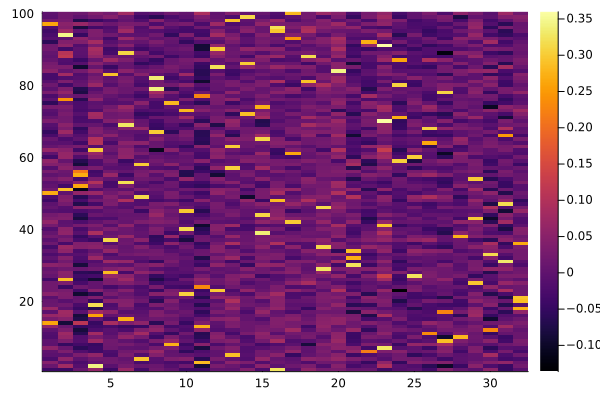

In [148]:
heatmap(qkvs[:,:,1])

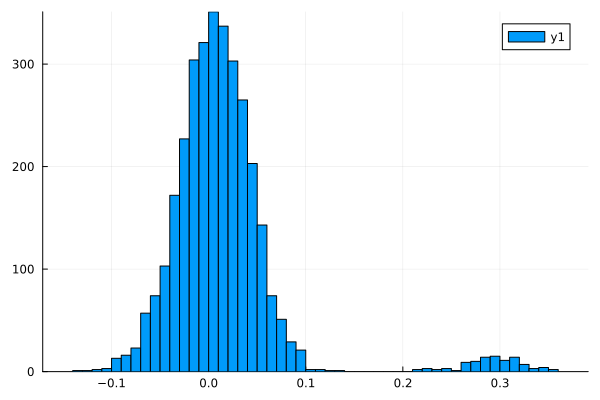

In [149]:
histogram(qkvs|>vec)

In [150]:
ps, st = Lux.setup(rng, sha)

((q_proj = (layer_1 = NamedTuple(),), k_proj = (layer_1 = NamedTuple(),), v_proj = (layer_1 = (weight = Float32[0.055781443 0.008696165 … -0.0026720257 0.0061550876; -0.046901967 0.031083463 … -0.016018966 -0.035056334; … ; -0.061055448 -0.016079877 … 0.03212913 0.07289169; -0.0570927 0.013858328 … 0.036701392 -0.0062334146], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),), out_proj = (layer_1 = (weight = Float32[-0.040231552 0.028522091 … 0.008139037 0.05768819; 0.044195887 -0.010561176 … 0.038589608 0.019881561; … ; 0.13639258 0.01563895 … 0.057213962 0.005144605; -0.020919196 0.05991899 … 0.03905618 0.0054578786], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [151]:
PhasorDense(kvs, ps.v_proj, st.v_proj)

LoadError: MethodError: no method matching PhasorDense(::Array{Float64, 3}, ::@NamedTuple{layer_1::@NamedTuple{weight::Matrix{Float32}, bias_real::Vector{Float32}, bias_imag::Vector{Float32}}}, ::@NamedTuple{layer_1::@NamedTuple{}})
The type `PhasorDense` exists, but no method is defined for this combination of argument types when trying to construct it.

[0mClosest candidates are:
[0m  PhasorDense(::Any, ::Any, ::Any, [91m::Any[39m, [91m::Any[39m)
[0m[90m   @[39m [35mMain.PhasorNetworks[39m [90m~/code/PhasorNetworks.jl/src/[39m[90m[4mnetwork.jl:59[24m[39m
[0m  PhasorDense([91m::Pair{<:Integer, <:Integer}[39m; init, return_solution, phase_bias)
[0m[90m   @[39m [35mMain.PhasorNetworks[39m [90m~/code/PhasorNetworks.jl/src/[39m[90m[4mnetwork.jl:90[24m[39m
[0m  PhasorDense([91m::AbstractMatrix[39m; return_solution, phase_bias)
[0m[90m   @[39m [35mMain.PhasorNetworks[39m [90m~/code/PhasorNetworks.jl/src/[39m[90m[4mnetwork.jl:80[24m[39m
[0m  ...


In [137]:
sha(ddx, kvs, ps, st)

LoadError: MethodError: no method matching (::PhasorDense)(::Array{Float64, 3}, ::@NamedTuple{weight::Matrix{Float32}, bias_real::Vector{Float32}, bias_imag::Vector{Float32}}, ::@NamedTuple{})
The object of type `PhasorDense` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.

[0mClosest candidates are:
[0m  (::PhasorDense)([91m::CurrentCall[39m, ::Union{SubArray, ComponentArray, NamedTuple}, ::NamedTuple)
[0m[90m   @[39m [35mMain.PhasorNetworks[39m [90m~/code/PhasorNetworks.jl/src/[39m[90m[4mnetwork.jl:120[24m[39m
[0m  (::PhasorDense)([91m::SpikingCall[39m, ::Union{SubArray, ComponentArray, NamedTuple}, ::NamedTuple)
[0m[90m   @[39m [35mMain.PhasorNetworks[39m [90m~/code/PhasorNetworks.jl/src/[39m[90m[4mnetwork.jl:115[24m[39m
[0m  (::PhasorDense)([91m::AbstractVecOrMat[39m, ::Union{SubArray, ComponentArray, NamedTuple}, ::NamedTuple)
[0m[90m   @[39m [35mMain.PhasorNetworks[39m [90m~/code/PhasorNetworks.jl/src/[39m[90m[4mnetwork.jl:110[24m[39m


In [112]:
struct SingleHeadTransformerBlock <: LuxCore.AbstractLuxContainerLayer{(:attn, :norm1, :norm2, :ff)}
    attn::SingleHeadAttention
    norm1
    norm2
    ff
end

In [ ]:
function SingleHeadTransformerBlock(d_input::Int, d_model::Int, d_ff::Int; dropout=0.1)
    SingleHeadTransformerBlock(
        SingleHeadAttention(d_input, d_model),
        LayerNorm((d_model,)),
        LayerNorm((d_model,)),
        Chain(
            Dense(d_model, d_ff, relu),
            Dropout(dropout),
            Dense(d_ff, d_model)
        )
    )
end

In [ ]:
function (tb::SingleHeadTransformerBlock)(x, mask, ps, st)
    # Attention path
    norm_x = tb.norm1(x, ps.norm1, st.norm1)[1]
    attn_out, st_attn = tb.attn(norm_x, mask, ps.attn, st.attn)
    x = x .+ attn_out
    
    # Feed-forward path
    norm_x = tb.norm2(x, ps.norm2, st.norm2)[1]
    ff_out, st_ff = tb.ff(norm_x, ps.ff, st.ff)
    x = x .+ ff_out
    
    return x, merge(st_attn, st_ff)
end

In [ ]:
# Usage example
d_model = 512
d_ff = 2048
rng = Random.default_rng()

model = SingleHeadTransformerBlock(d_model, d_ff)
ps, st = Lux.setup(rng, model)

# Input: (sequence_length × features × batch_size)
x = randn(Float32, 32, d_model, 1)
output, st = model(x, nothing, ps, st)